In [1]:
import pandas as pd
from scipy.integrate import odeint
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import random
from statistics import mean 
import itertools
import math

In [2]:
path_file="https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
dataset=pd.read_csv(path_file,parse_dates=['data'])
# guariti,infetti,sani, morti 
dataset['asintomatici']= dataset['totale_casi'] * 0.44 
dataset['immuni'] = dataset['dimessi_guariti'] * 0.95  #verificare proporzione
data=dataset[['totale_positivi','dimessi_guariti','deceduti','asintomatici','immuni']]
data_first=pd.read_csv(path_file)['data'][0][:-9]
data_last=pd.read_csv(path_file)['data'][data.shape[0]-1][:-9]

In [3]:
data

,totale_positivi,dimessi_guariti,deceduti,asintomatici,immuni
0,221,1,7,100.76,0.95
1,311,1,10,141.68,0.95
2,385,3,12,176.00,2.85
3,588,45,17,286.00,42.75
4,821,46,21,390.72,43.70
5,1049,50,29,496.32,47.50
6,1577,83,34,745.36,78.85
7,1835,149,52,895.84,141.55
8,2263,160,79,1100.88,152.00
9,2706,276,107,1359.16,262.20


In [4]:
def initializeParameters(mink1,maxk1,mink5,maxk5):
    tupla= tuple([random.uniform(mink1,maxk1) for i in range(0,1)])
    #tupla1=tuple([random.uniform(mink3,maxk3) for i in range(0,3)])
    tupla2=tuple([random.uniform(mink5,maxk5) for i in range(0,2)])
    
    ris=(tupla[0],tupla2[0],tupla2[1])
    return(ris)

In [5]:
def deriv(y,t,k1,k5,k6):  
    '''set di equazioni differenziali'''
    Sani            =   y[0]
    Infetti         =   y[1]
   
    Morti           =   y[2]
    Guariti         =   y[3]
    #Immuni          =   y[5]
    dSanidt =  -k1*Sani*Infetti 
    dInfettidt = k1*Sani*Infetti-k5*Infetti-k6*Infetti
    
    dMortidt=k5*Infetti
    dGuaritidt =k6*Infetti
    
    return [dSanidt,dInfettidt,dMortidt,dGuaritidt]

In [6]:

def diffusione(parameters,Sani =60000000, Infetti=221,Guariti=1, Morti= 7,Immuni = 0,orizzonte_temporale_in_gg=data.shape[0]):
        y0 =  (Sani,Infetti,Morti,Guariti)
        t = np.arange(0,orizzonte_temporale_in_gg)
        ret = odeint(deriv, y0, t,args=tuple(parameters))
        return(ret)

def fitness(previsti):
        df=pd.DataFrame(previsti,columns=['sani','totale_positivi','dimessi_guariti','deceduti'])
        df=df.drop(columns=['sani'])
        dataframe=((df-data)**2)
        lista=dataframe.values.tolist()
        merged = list(itertools.chain.from_iterable(lista))
        media=mean(merged)
        return media 

In [7]:
def perturbazione(ls):
    sup1 = 5e-19
    sup2=5e-8
    sup3=5e-4
    #sup4=1e-1
    for i in (0,1):
        if ls[i] < 9e-19:
            ls[i]=random.uniform(ls[i],ls[i]+sup1)
        else:
            ls[i]=random.uniform(0,ls[i]-sup1)
    for i in (2,3,6):
        if ls[i] < 9e-7:
            ls[i]=random.uniform(ls[i],ls[i]+sup2)
        else:
            ls[i]=random.uniform(0,ls[i]-sup2)
    for i in (4,5):
        if ls[i] < 1e-4:
            ls[i]=random.uniform(ls[i],ls[i]+sup3)
        else:
            ls[i]=random.uniform(0,ls[i]-sup3)
    #for i in (7,8):
     # #  if ls[i] < 5e-1:
        #    ls[i]=random.uniform(ls[i],ls[i]+sup4)
        #else:
         #   ls[i]=random.uniform(0,ls[i]-sup4)
    
    
    return(ls)

In [8]:
def localsearch(iniziale,iterazioni,mink1,maxk1,mink5,maxk5,param_only=True):#,mink8,maxk8
        #list(initializeParameters(minimo,massimo))
        k=iniziale.copy()
        errore= math.inf
        val='1'
        set_ottimo=[]
        for c in range(iterazioni):
            valori=diffusione(k)
            stimaerrore=fitness(valori)
            if stimaerrore<errore:
                errore=stimaerrore
                val=valori 
                set_ottimo=iniziale
            iniziale = list(initializeParameters(mink1,maxk1,mink5,maxk5))#,mink8,maxk8
            k=iniziale.copy()
        if param_only==True : 
            return set_ottimo
        else : 
            return (set_ottimo,val,errore)

In [9]:
a=list(initializeParameters(mink1=1e-10,maxk1=8e-10,mink5=1e-9,maxk5=1e-6))

In [10]:
o=localsearch(a,iterazioni=10,mink1=1e-10,maxk1=8e-10,mink5=1e-9,maxk5=1e-6,param_only=False)

In [12]:
a

[3.5871838510012336e-10, 9.73737612348213e-07, 8.317103512394559e-07]

In [13]:
def ils(iterazioni=10,mink1=1e-20,maxk1=1e-17,mink3=5e-9,maxk3=5e-7,mink5=9e-5,maxk5=1e-2,param_only=True):#,mink8=9e-1,maxk8=9e-1
        iniziale = list(initializeParameters(mink1,maxk1,mink3,maxk3,mink5,maxk5))#,mink8,maxk8
        loc_search = localsearch(iniziale,iterazioni,mink1,maxk1,mink3,maxk3,mink5,maxk5,param_only=False)#,mink8,maxk8
        k=loc_search[0]
        best_val = loc_search[1]
        best_errore = loc_search[2]
        val=0
        for c in range(iterazioni):
            val=best_val
            nuova_iniziale = perturbazione(k)
            loc_search = localsearch(nuova_iniziale,iterazioni,mink1,maxk1,mink3,maxk3,mink5,maxk5,param_only=False)#,mink8,maxk8
            val = loc_search[1]
            if loc_search[2] < best_errore: # Se nuovo errore minore best si aggiorna il best
                best_errore = loc_search[2]
                best_val= loc_search[1]
                k=loc_search[0]
        if param_only == True : 
            return k
        else : return k,best_val,best_errore  


In [14]:
def grafico(stato):
    d={'Sani':0,'Infetti':1,'Deceduti':2,'Guariti':3}
    col={'Sani':'b--','Infetti':'r','Asintomatici':'y','Deceduti':'k','Guariti':'g','Immuni':'grey'}
    plt.plot(ret[:,d[stato]], col[stato], alpha=0.7 ,lw=2, label=stato)
    plt.xlabel('Tempo (in giorni)')
    plt.ylabel('Popolazione')
    plt.axvline(data.shape[0],color='grey')
    plt.text(0,ret[:,d[stato]].mean(),data_last)
    plt.legend()
    plt.show()

In [15]:
prova=ils()

TypeError: initializeParameters() takes 4 positional arguments but 6 were given

In [16]:
a=list(initializeParameters(mink1=9e-10,maxk1=3e-9,mink5=1e-4,maxk5=1e-3)) ############RANGE GIUSTOOO

In [17]:
t = np.linspace(0,120)

In [18]:
ret=diffusione(a,orizzonte_temporale_in_gg=70)

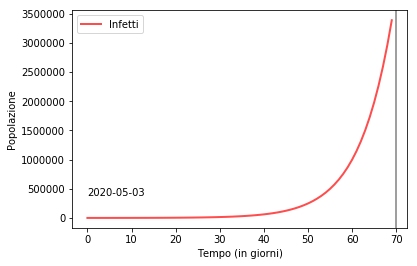

In [20]:
grafico('Infetti')

In [21]:
a

[2.3607610988842355e-09, 0.0002914665555942526, 0.0008261499221525842]